### Data preprocessing 


#### 1. Exploratory analysis & Outlier detection



In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

#### Load data

1. AquaStat 

In [2]:
df = pd.read_csv('clean data/aqua_socec_clean.csv', index_col=0)
df.sample(5)

,country,variable,1998-2002,2003-2007,2008-2012,2013-2017
612,GNQ,Total population with access to safe drinking-...,47.300000,47.400000,47.700000,47.900000
1153,MDG,Urban population with access to safe drinking-...,76.300000,78.400000,80.400000,81.600000
2152,VEN,Total population with access to safe drinking-...,91.500000,92.200000,92.900000,93.100000
179,BEL,GDP per capita (current US$/inhab),24811.613253,43962.176891,44767.358857,44118.925664
2090,TZA,Rural population (1000 inhab),27785.622000,30972.693000,34606.978000,38367.191000


In [3]:
# rename year period to merge with water stress indicators
df.rename(columns = {'country':'Country' ,
                     '1998-2002':'2002', 
                     '2003-2007': '2007', 
                     '2008-2012': '2012',
                     '2013-2017':'2017'}, inplace = True)

2. Water stress data

In [4]:
df_ws = pd.read_csv('clean data/water_stress.csv')
df_ws.sample(5)

,Country,Year,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
522,PRY,2002,0.212489,NaN,0.626736
473,NOR,2002,0.649884,NaN,1.942238
178,DOM,2002,21.731915,6.095134,28.303037
156,CYP,2012,32.730769,71.713800,34.896118
511,PRI,2007,14.166761,26.742765,22.456798


In [5]:
df_ws["Year"].unique()
df_ws["Year"] = df_ws["Year"].astype("string")
df_ws["Year"] = df_ws["Year"].astype("object")
df_ws["Year"].unique()

array(['2002', '2007', '2012', '2017'], dtype=object)

3. UNICEF dataset

In [6]:
df_unif = pd.read_csv('clean data/unicef_socec_clean.csv', index_col=0)
df_unif.sample(5)

,Indicator,Country,Time,Value
53588,Total debt service (% of GNI),HTI,2015,4.000000e-01
25515,GDP deflator (base year varies by country),BWA,2001,7.010000e+01
9451,Population growth (annual %),AUS,2004,1.200000e+00
38651,"GDP, PPP (current international $)",COD,2006,3.084360e+10
10711,Population growth (annual %),CIV,2019,2.500000e+00


In [7]:
df_unif.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 80784 entries, 0 to 133772
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Indicator  80784 non-null  object 
 1   Country    80784 non-null  object 
 2   Time       80784 non-null  int64  
 3   Value      80784 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.1+ MB


In [8]:
# transform type indicators and slice length name
df["variable"] = df["variable"].astype("string")
df['variable'].unique()
df["variable"] = df['variable'].str.slice(0,35)
df['variable'].unique()

<StringArray>
[      'Rural population (1000 inhab)',       'Urban population (1000 inhab)',
      'Population density (inhab/km2)',  'GDP per capita (current US$/inhab)',
 'Human Development Index (HDI) [high', 'Total population with access to saf',
 'Rural population with access to saf', 'Urban population with access to saf']
Length: 8, dtype: string

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1120 entries, 0 to 2187
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Country   1120 non-null   object 
 1   variable  1120 non-null   string 
 2   2002      1120 non-null   float64
 3   2007      1120 non-null   float64
 4   2012      1120 non-null   float64
 5   2017      1120 non-null   float64
dtypes: float64(4), object(1), string(1)
memory usage: 61.2+ KB


In [10]:
# transform data aquastat long format (year as attribute)
df_melt = pd.melt(df, id_vars=["Country","variable"], 
        var_name="Year", 
        value_name="value")
df_melt.head(5)

,Country,variable,Year,value
0,AFG,Rural population (1000 inhab),2002,17086.910000
1,AFG,Urban population (1000 inhab),2002,4893.013000
2,AFG,Population density (inhab/km2),2002,34.618096
3,AFG,GDP per capita (current US$/inhab),2002,194.958382
4,AFG,Human Development Index (HDI) [high,2002,0.378000


In [11]:
# transform data aquastat wide format (indicators as attributes)
df_piv = df_melt.pivot_table(values='value', 
                             index=['Year','Country'], 
                             columns='variable',
                             fill_value=0)
df_piv = df_piv.reset_index()

In [12]:
df_piv.head(5)

variable,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf
0,2002,AFG,194.958382,0.378,34.618096,17086.910,27.6,33.8,4893.013,55.9
1,2002,AGO,869.851352,0.419,14.052633,8353.851,37.0,45.7,9218.798,62.6
2,2002,ALB,1396.545492,0.680,108.736939,1762.229,93.5,96.1,1356.800,99.5
3,2002,ARE,31720.544451,0.793,41.612165,664.034,100.0,99.7,2843.198,99.6
4,2002,ARG,2918.591423,0.770,13.552636,3974.741,83.7,96.7,33914.629,98.2


In [13]:
# merge aquastat with water stress. 
# left merge to only keep aquastat countries
df_piv_ws = pd.merge(df_piv, df_ws, on=["Country", "Year"], how='left')
df_piv_ws.sample(5)

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
258,2007,SWZ,3047.496058,0.482,60.060599,889.921,57.3,64.8,248.513,91.6,23.680710,2.818049,77.559913
43,2002,FIN,26805.051927,0.867,15.417318,912.167,100.0,100.0,4301.206,100.0,3.773883,NaN,9.844134
35,2002,DJI,790.680910,0.376,32.195776,174.439,62.6,83.7,571.782,90.1,6.333333,NaN,6.333333
12,2002,BGD,345.494326,0.485,892.348687,102783.564,75.5,77.5,33817.103,83.7,NaN,NaN,NaN
31,2002,CPV,1562.052203,0.576,109.913400,202.789,81.7,83.7,249.317,85.3,7.600000,31.821550,7.600000


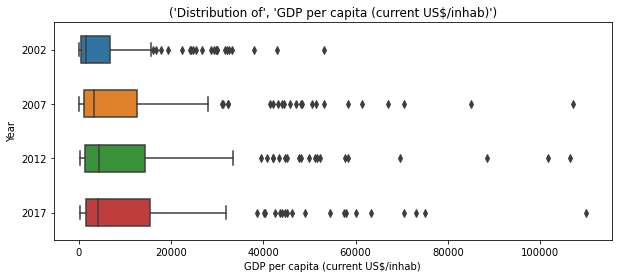

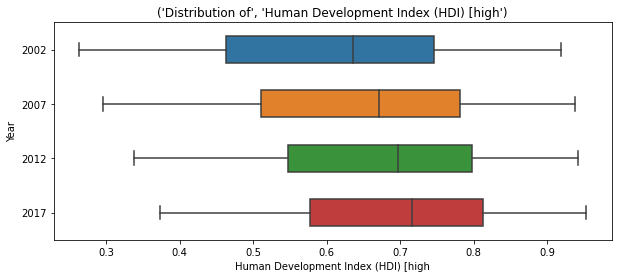

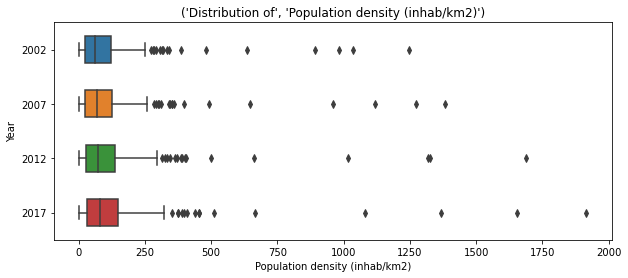

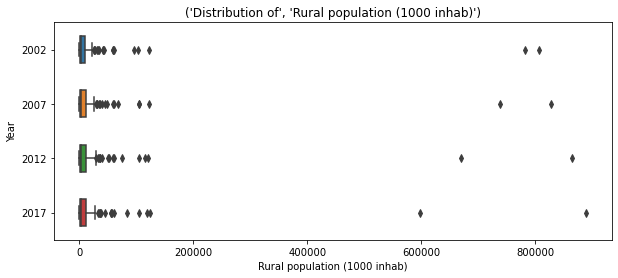

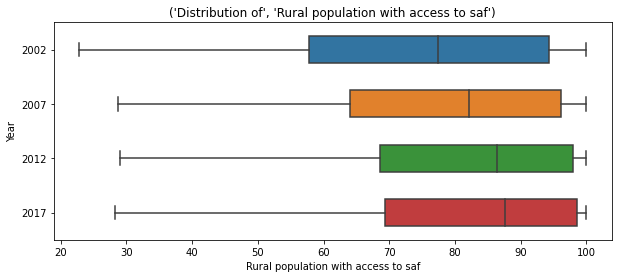

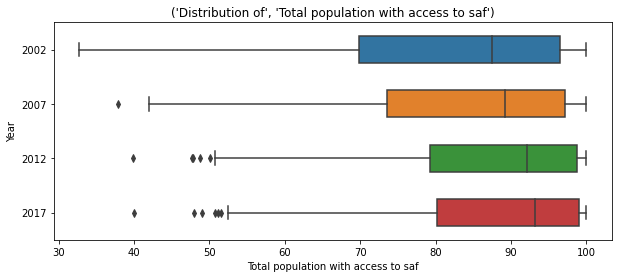

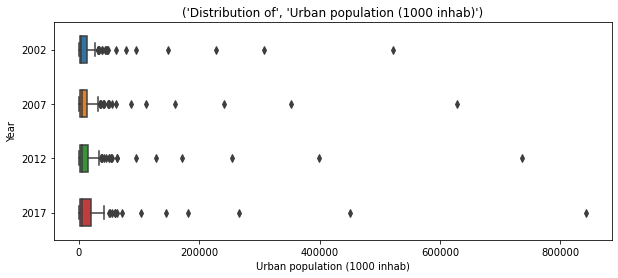

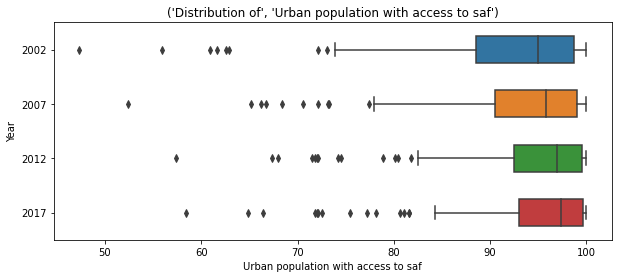

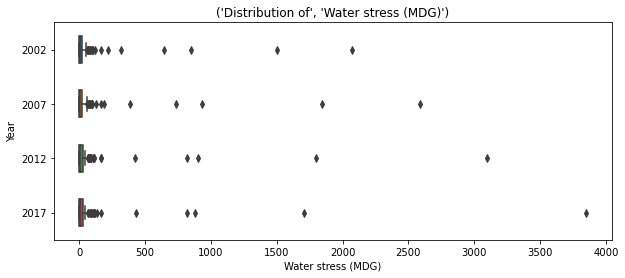

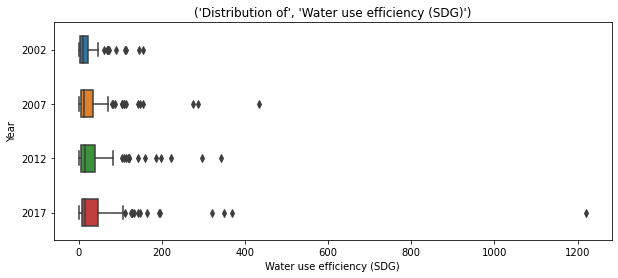

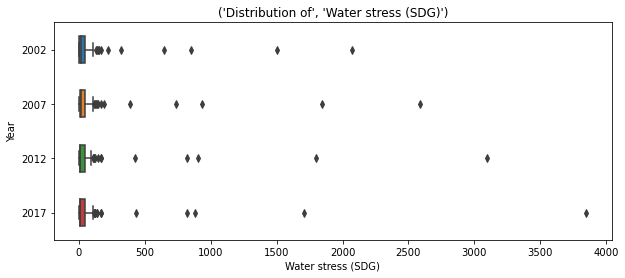

In [14]:
# Distribution per indicator en time period
#variable = df['variable'].unique()

variable = df_piv_ws.columns[2:]

for i in variable:
    plt.figure(figsize=(10,4))
    sns.boxplot(data = df_piv_ws, x = i ,y ='Year', width=0.5)
    plt.title(("Distribution of", i)) 

In [15]:
# quick check for one time period
df_p = df[['Country','variable','2017']]
# df_p.head(10)

In [ ]:
# df_p.describe()

In [16]:
df_p = df_p.pivot('Country','variable','2017')
#corr_data = df_p.corr()

In [17]:
# transform variables (std) before heatmap
scaler = StandardScaler()
# get numeric data

num_d = df_p.select_dtypes(include=['float64'])

# update the cols with their normalized values
df_p[num_d.columns] = scaler.fit_transform(num_d)

<AxesSubplot:xlabel='variable', ylabel='Country'>

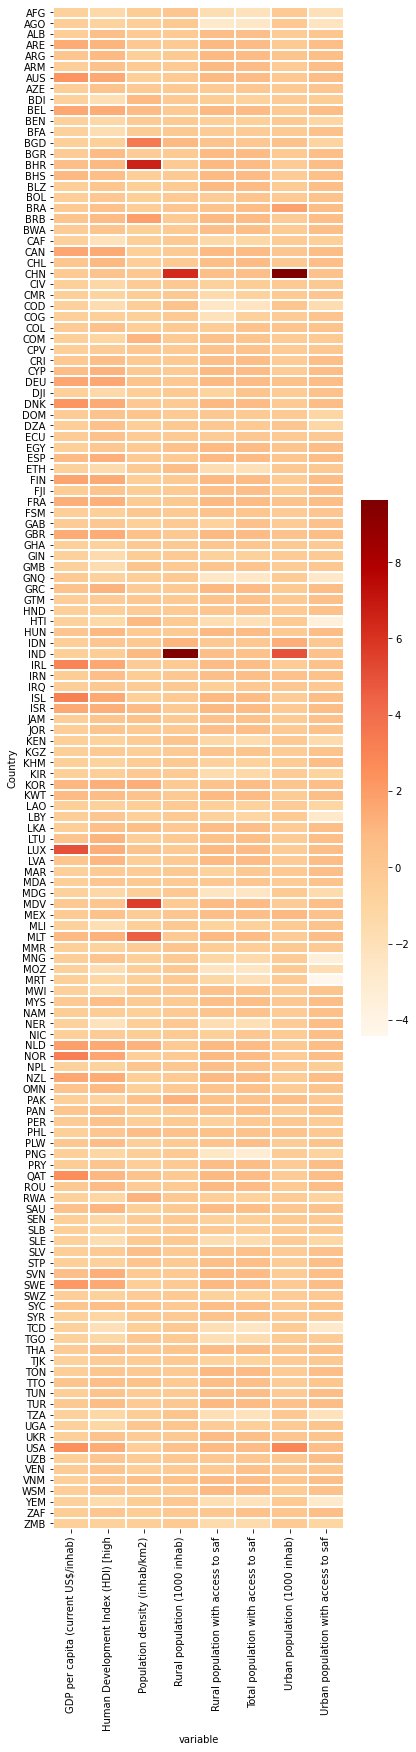

In [18]:
plt.subplots(figsize=(6,.2*(len(df_p.index))))
sns.heatmap(df_p,      
            cbar_kws={'fraction' : 0.08}, # shrink colour bar
            cmap='OrRd', # use orange/red colour map
            linewidth=1)

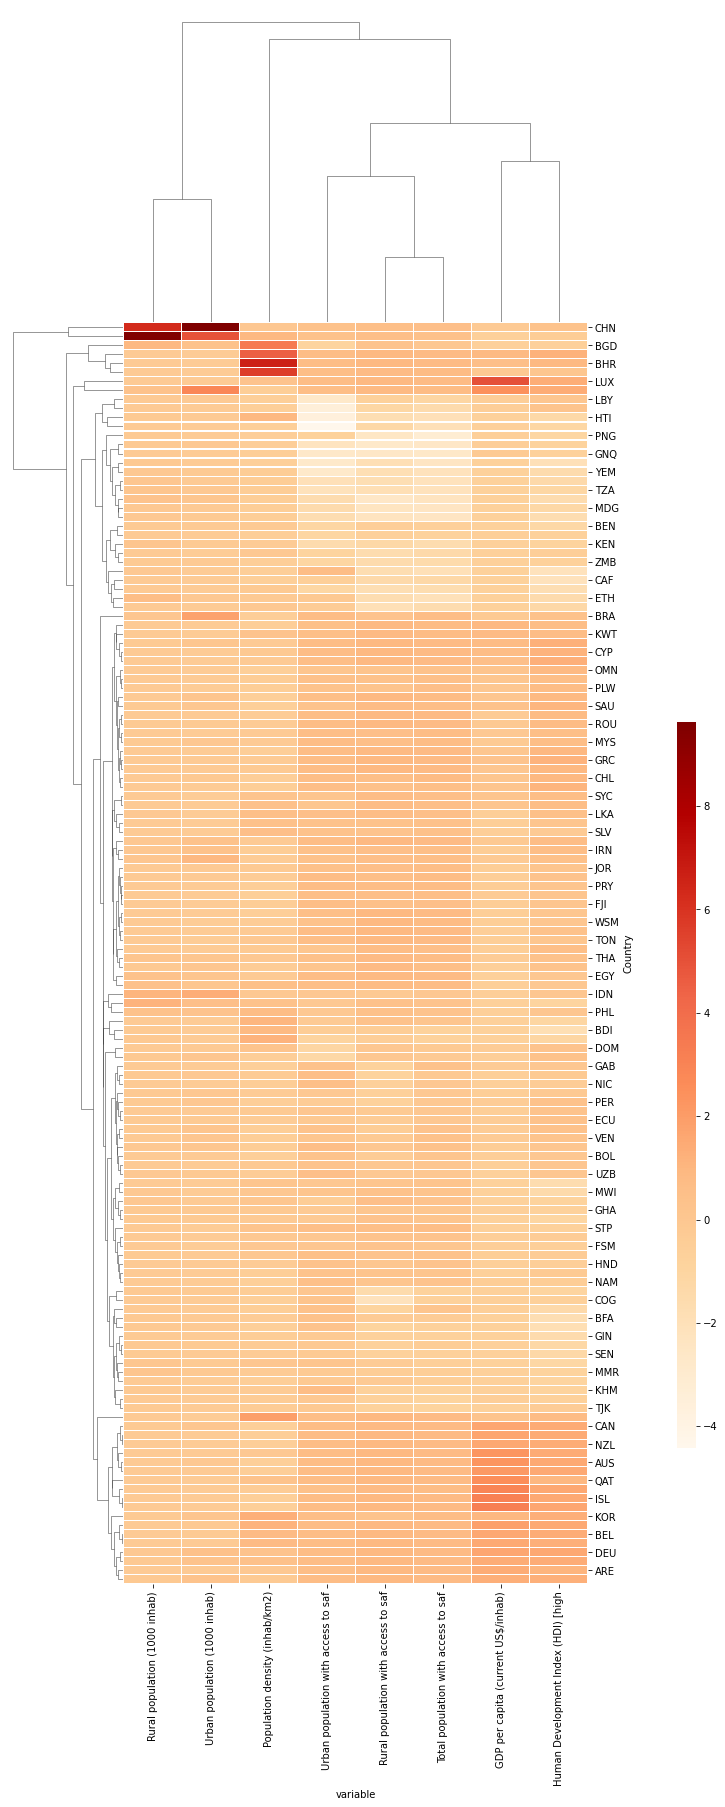

In [19]:
sns.clustermap(df_p, 
               linewidth=0.05,
               cmap='OrRd',
               figsize=(9,(.18*(len(df_p.index)))),
               cbar_pos=(1.05, .2, .03, .4))

# Rural & total pop with access to water 
# Rutal & total pop per 1000 habs same: decide which to drop


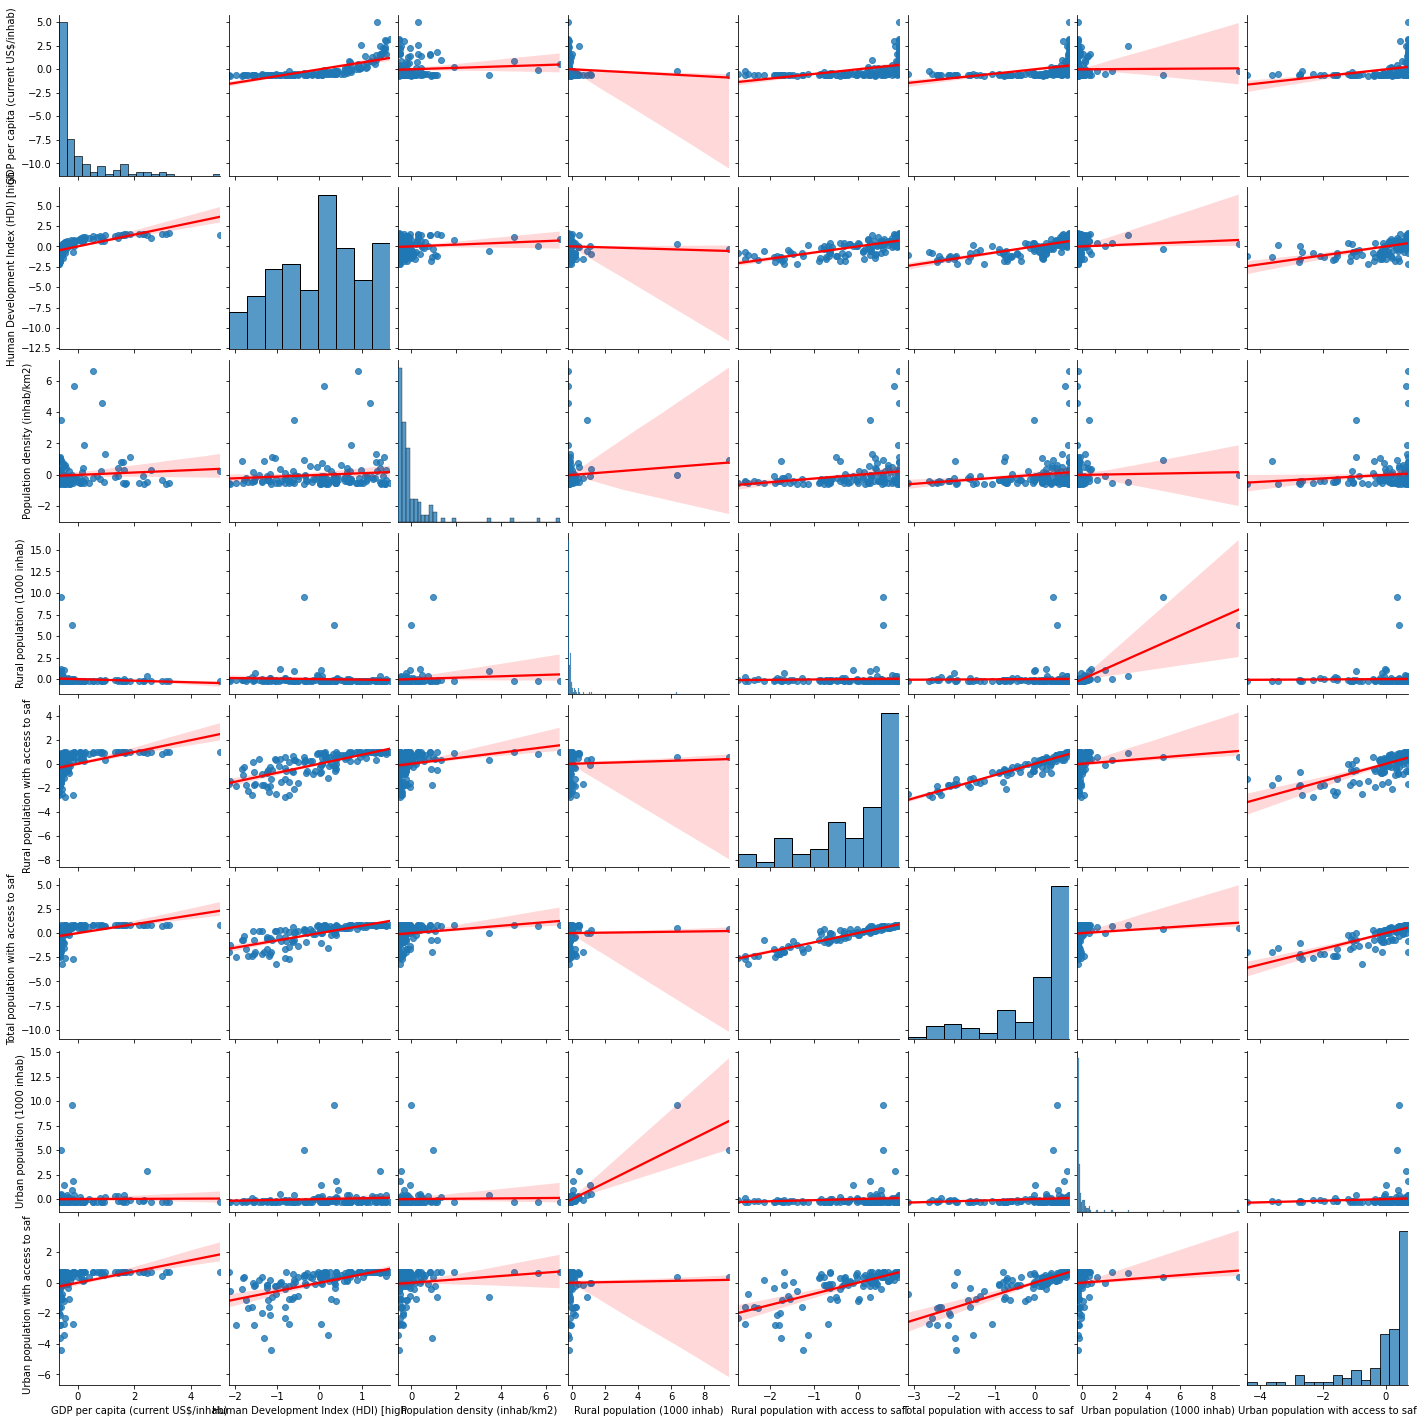

In [20]:
sns.pairplot(df_p,kind="reg", plot_kws={'line_kws':{'color':'red'}})

In [ ]:
#sns.pairplot(df_p,kind="reg")
#plot_kws={'line_kws':{'color':'red'}})

### Exploratory analysis AquaStat and Water Stress




In [21]:
# Exploratory analysis aquastat and ws (one time period)
df_piv_ws_17 = df_piv_ws.loc[df_piv_ws.Year == '2017']
df_piv_ws_17.sample(5)

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
557,2017,YEM,854.926716,0.463,52.720456,18075.808,46.5,54.9,10174.612,72.0,169.761905,5.219357,169.761905
477,2017,HUN,14556.367247,0.841,104.588015,2813.212,100.0,100.0,6908.347,100.0,4.325962,23.880203,7.770294
445,2017,CIV,1570.209076,0.512,75.784500,12068.187,68.8,81.9,12226.563,93.1,1.381032,23.167322,5.087566
492,2017,KWT,28897.241961,0.809,227.614983,0.000,99.0,99.0,4136.528,99.0,3850.500000,102.435536,3850.500000
429,2017,BEL,44118.925664,0.917,374.050049,233.097,100.0,100.0,11196.239,100.0,21.825137,106.071515,49.066339


In [22]:
df_piv_ws_17.describe()

,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
count,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,132.000000,129.000000,132.000000
mean,13134.444841,0.699629,154.628324,22224.068357,81.530000,87.288571,25767.408229,94.205000,76.716541,49.664064,85.088501
std,19323.264081,0.152774,267.189948,91319.925924,19.532414,15.024881,85209.040162,8.136155,378.614091,121.678596,377.929927
min,296.110481,0.373000,1.990764,0.000000,28.200000,40.000000,17.245000,58.400000,0.005529,0.685503,0.027446
25%,1581.047202,0.576750,30.771496,880.254500,69.350000,80.200000,1837.374500,93.050000,1.322266,6.656907,3.394164
50%,4206.750787,0.716500,79.287521,3947.505000,87.650000,93.200000,5364.441500,97.400000,5.258066,13.616564,10.324766
75%,15419.502516,0.813000,149.684302,12863.151000,98.550000,99.025000,19035.030750,99.700000,26.845612,46.509821,45.697098
max,110003.247419,0.953000,1915.482051,889216.746000,100.000000,100.000000,843314.783000,100.000000,3850.500000,1221.061026,3850.500000


In [23]:
df_piv_ws_17.nlargest(5,'Water use efficiency (SDG)')
# looking above boxplot per year Water eff for luxemburg might be an outlier 

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
497,2017,LUX,110003.247419,0.908,228.536680,54.103,100.0,100.0,529.352,100.0,1.302857,1221.061026,3.781095
456,2017,DNK,57454.289221,0.929,140.050672,701.971,100.0,100.0,5031.580,100.0,12.351667,368.612902,20.040562
480,2017,IRL,70492.921726,0.939,67.633452,1764.335,97.8,97.9,2997.322,97.9,1.455769,349.767068,3.642926
468,2017,GBR,40286.571861,0.919,273.911009,11156.164,100.0,100.0,55025.421,100.0,5.727211,319.736428,14.354646
537,2017,SWE,54541.574444,0.935,22.137309,1273.943,100.0,100.0,8636.758,100.0,1.364943,194.076472,3.427128


In [24]:
df_piv_ws_17.nlargest(5,'GDP per capita (current US$/inhab)')
# Luxemburg has low population density and largest water use efficiency + highest GDP 

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
497,2017,LUX,110003.247419,0.908,228.536680,54.103,100.0,100.0,529.352,100.0,1.302857,1221.061026,3.781095
516,2017,NOR,75092.402428,0.953,13.749263,961.814,100.0,100.0,4343.569,100.0,0.684758,128.770322,2.046464
483,2017,ISL,73108.083207,0.935,3.246534,20.862,100.0,100.0,314.163,100.0,0.170588,58.338989,0.394075
480,2017,IRL,70492.921726,0.939,67.633452,1764.335,97.8,97.9,2997.322,97.9,1.455769,349.767068,3.642926
527,2017,QAT,63249.467320,0.848,237.139077,24.338,100.0,100.0,2614.873,100.0,432.413793,191.638949,432.413793


In [25]:
df_piv_ws_17.nlargest(5,'Water stress (MDG)')

,Year,Country,GDP per capita (current US$/inhab),Human Development Index (HDI) [high,Population density (inhab/km2),Rural population (1000 inhab),Rural population with access to saf,Total population with access to saf,Urban population (1000 inhab),Urban population with access to saf,Water stress (MDG),Water use efficiency (SDG),Water stress (SDG)
492,2017,KWT,28897.241961,0.809,227.614983,0.000,99.0,99.0,4136.528,99.0,3850.500000,102.435536,3850.500000
423,2017,ARE,40180.344045,0.864,133.584948,1292.709,100.0,99.6,8107.436,99.6,1708.000000,92.773763,1708.000000
530,2017,SAU,20905.391689,0.856,15.398117,5394.590,97.0,97.0,27543.623,97.0,883.333333,28.270985,883.333333
494,2017,LBY,3940.670630,0.704,3.740025,1286.565,68.3,71.2,5088.051,72.1,817.142857,3.793108,817.142857
527,2017,QAT,63249.467320,0.848,237.139077,24.338,100.0,100.0,2614.873,100.0,432.413793,191.638949,432.413793


In [26]:
corr_data = df_piv_ws_17.corr()

<AxesSubplot:>

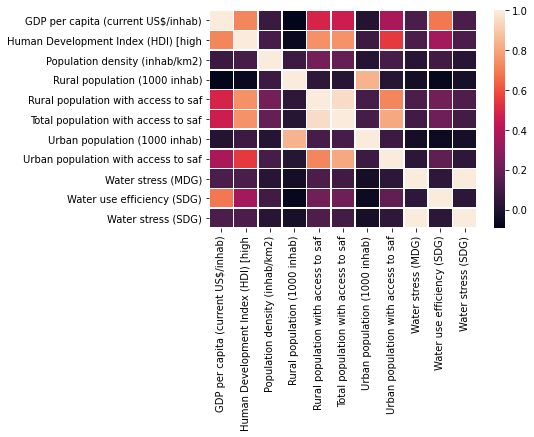

In [27]:
sns.heatmap(corr_data,
           linewidths=.5)

# drop: - Rural or urban pop with access to saf
#       - WS (MDG) or (SDG)
#       - Rural & Urban pop(1000 inhab) 

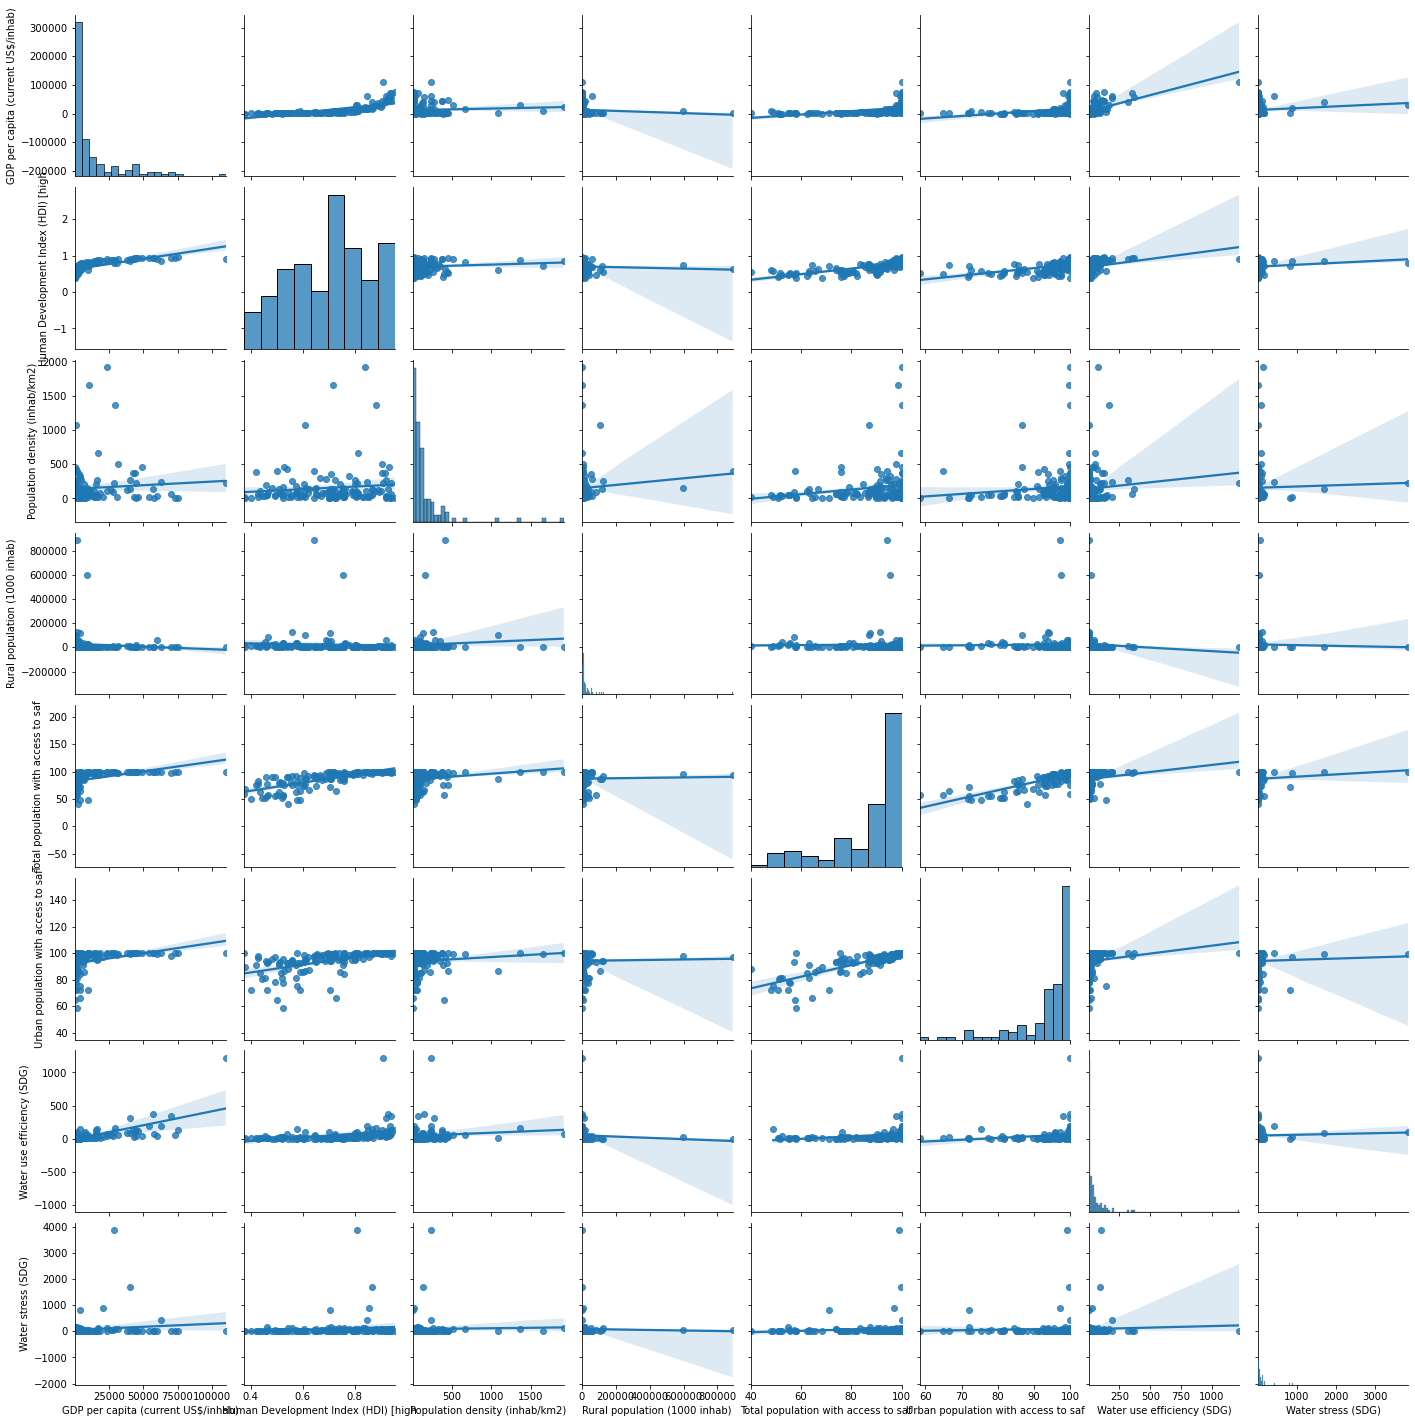

In [28]:
df_keep = df_piv_ws_17.loc[:, ~df_piv_ws_17.columns.isin(['Rural population with access to saf',
                                       'Water stress (SDG)',
                                       'Urban population (1000 inhab)'])]
sns.pairplot(df_keep,kind="reg")
#plot_kws={'line_kws':{'color':'red'}})

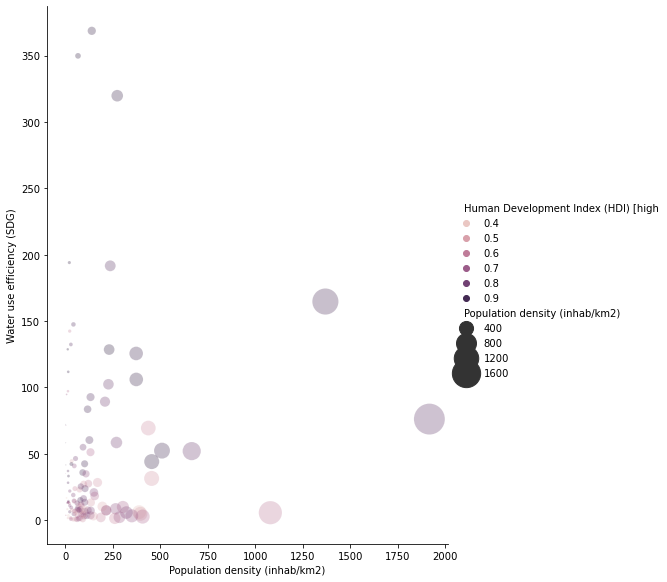

In [29]:
# After removing LUX

#g.set(xscale="log", yscale = "log")

df_replot = df_piv_ws_17.loc[~((df_piv_ws_17['Country'] == 'LUX')),:]
g = sns.relplot(x="Population density (inhab/km2)", y='Water use efficiency (SDG)',
               size="Population density (inhab/km2)",
                hue = 'Human Development Index (HDI) [high',
                alpha =0.3,
      #          style="event",
      #          col="country",
                height=8, aspect=.8, 
                #kind="line", 
              sizes=(0,0.5*max(df_replot["Population density (inhab/km2)"])),
                data=df_replot)



In [ ]:
g = sns.relplot(x="GDP per capita (current US$/inhab)", y='Water use efficiency (SDG)',
                size="Population density (inhab/km2)",
                hue = 'Human Development Index (HDI) [high',
                alpha =0.3,
      #         style="event",
      #         col="country",
                height=5, aspect=.8, 
                #kind="line", 
                sizes=(0,0.5*max(df_piv_ws_17["Population density (inhab/km2)"])),
                data=df_piv_ws_17)

3. Exploratory UNICEF dataset

In [31]:
df_unif.isnull().sum()

Indicator    0
Country      0
Time         0
Value        0
dtype: int64

In [32]:
# UNICEF includes 30 indicators fot 21 years.
df_unif["Indicator"].unique()

array(['Fertility rate, total (births per woman)',
       'Life expectancy at birth, total (years)',
       'Mortality rate, infant (per 1,000 live births)',
       'Population growth (annual %)',
       'Prevalence of HIV, total (% of population ages 15-49)',
       'GDP (current LCU)', 'GDP (current US$)',
       'GDP deflator (base year varies by country)',
       'GDP growth (annual %)', 'GDP per capita (current US$)',
       'GDP per capita, PPP (current international $)',
       'GDP, PPP (current international $)',
       'General government total expenditure (current LCU)',
       'GNI per capita, Atlas method (current US$)',
       'GNI per capita, PPP (current international $)',
       'PPP conversion factor, GDP (LCU per international $)',
       'Total debt service (% of GNI)',
       'Population aged 25-64 years (thousands) ',
       'Total population (thousands)', 'GNI per capita (current LCU)',
       'GDP (constant LCU)',
       'Official exchange rate (LCU per US$, per

In [33]:
# Filter only 2017
df_unif['Time'] = df_unif['Time'].astype('string') 
df_unif = df_unif.loc[df_unif.Time == '2017']
df_unif.sample(4)

,Indicator,Country,Time,Value
8444,"Mortality rate, infant (per 1,000 live births)",MWI,2017,34.0
26890,GDP deflator (base year varies by country),MYS,2017,105.5
13033,"Prevalence of HIV, total (% of population ages...",AZE,2017,0.1
104207,GDP per capita (current LCU),BEL,2017,39204.0


In [34]:
# transform data wide format (indicators as attributes)
df_unif_p = df_unif.pivot_table(values='Value', 
                             index=['Time','Country'], 
                             columns='Indicator',
                             fill_value=0)
df_unif_p = df_unif_p.reset_index()

In [35]:
df_unif_p.describe()

Indicator,DEC alternative conversion factor (LCU per US$),"Fertility rate, total (births per woman)",GDP (constant LCU),GDP (current LCU),GDP (current US$),GDP at market prices (constant 2010 US$),GDP deflator (base year varies by country),GDP growth (annual %),GDP per capita (current LCU),GDP per capita (current US$),...,"Mortality rate, infant (per 1,000 live births)","Official exchange rate (LCU per US$, period average)","PPP conversion factor, GDP (LCU per international $)","PPP conversion factor, private consumption (LCU per international $)",Population aged 25-64 years (thousands),Population growth (annual %),"Prevalence of HIV, total (% of population ages 15-49)",Price level ratio of PPP conversion factor (GDP) to market exchange rate,Total debt service (% of GNI),Total population (thousands)
count,140.000000,140.000000,1.400000e+02,1.400000e+02,1.400000e+02,1.400000e+02,140.000000,140.000000,1.400000e+02,140.000000,...,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,140.000000,1.400000e+02
mean,1037.171429,2.836429,1.769199e+14,2.808071e+14,4.813167e+11,4.642023e+11,219.968571,3.552143,3.685866e+06,13012.821429,...,23.257143,1031.435000,381.063286,398.356429,23578.650000,1.542857,1.440000,0.522143,2.819286,4.745544e+04
std,3841.591960,1.315935,1.072923e+15,1.774900e+15,1.996021e+12,1.772991e+12,464.207899,3.402992,1.764413e+07,19058.949947,...,19.745274,3767.690189,1393.541448,1479.881806,91074.664165,1.200428,3.911315,0.241121,4.433309,1.681159e+05
min,0.000000,0.000000,0.000000e+00,2.443580e+08,0.000000e+00,0.000000e+00,0.000000,-5.700000,2.141000e+03,0.000000,...,2.000000,0.000000,0.000000,0.000000,0.000000,-2.200000,0.000000,0.000000,0.000000,0.000000e+00
25%,1.925000,1.800000,6.982886e+10,1.652387e+11,1.150203e+10,1.230110e+10,103.425000,1.975000,3.087775e+04,1570.000000,...,7.000000,2.075000,1.150000,1.250000,1576.750000,0.800000,0.000000,0.400000,0.000000,2.939000e+03
50%,16.000000,2.400000,1.198472e+12,1.863736e+12,3.851408e+10,3.693462e+10,114.950000,3.700000,9.042850e+04,4190.000000,...,17.000000,18.150000,8.065000,8.750000,4665.000000,1.400000,0.200000,0.500000,1.200000,1.069800e+04
75%,570.800000,3.825000,7.437766e+12,1.247587e+13,2.266772e+11,2.220739e+11,174.325000,4.850000,6.222692e+05,15259.250000,...,36.000000,570.800000,210.197500,207.350000,14221.750000,2.500000,0.825000,0.600000,4.225000,3.157300e+04
max,34392.500000,7.000000,9.912928e+15,1.531653e+16,1.948539e+13,1.734863e+13,4069.400000,26.700000,1.898572e+08,107627.000000,...,86.000000,33226.300000,13061.290000,13944.900000,843003.000000,4.700000,28.400000,1.300000,37.700000,1.421022e+06


In [36]:
df_unif_p.nlargest(5,'Total debt service (% of GNI)')

Indicator,Time,Country,DEC alternative conversion factor (LCU per US$),"Fertility rate, total (births per woman)",GDP (constant LCU),GDP (current LCU),GDP (current US$),GDP at market prices (constant 2010 US$),GDP deflator (base year varies by country),GDP growth (annual %),...,"Mortality rate, infant (per 1,000 live births)","Official exchange rate (LCU per US$, period average)","PPP conversion factor, GDP (LCU per international $)","PPP conversion factor, private consumption (LCU per international $)",Population aged 25-64 years (thousands),Population growth (annual %),"Prevalence of HIV, total (% of population ages 15-49)",Price level ratio of PPP conversion factor (GDP) to market exchange rate,Total debt service (% of GNI),Total population (thousands)
87,2017,MNG,2439.8,2.9,16891768343078,27876297223766,11425755280,12447287566,165.0,5.3,...,15,2439.8,791.44,873.5,1585,1.9,0.1,0.3,37.7,3114
114,2017,SLV,1.0,2.1,24257490000,24979200000,24979200000,21983797186,103.0,2.2,...,12,1.0,0.46,0.5,2834,0.5,0.6,0.5,16.2,6388
13,2017,BGR,1.7,1.6,95989715000,102307942000,58950125036,59088843474,106.6,3.5,...,6,1.7,0.68,0.7,3955,-0.7,0.1,0.4,15.2,7102
105,2017,PNG,3.2,3.6,63926378089,72521646100,22742613554,20972968024,113.4,3.5,...,38,3.2,1.97,2.7,3453,2.0,0.8,0.6,12.5,8438
5,2017,ARM,482.7,1.8,5075556763753,5564493300000,11527458566,12364648565,109.6,7.5,...,12,482.7,155.97,167.3,1633,0.3,0.2,0.3,12.0,2945
